In [1]:
%cd -q ../..

%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import chain

import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from statsmodels import api as sm

from scotus_metalang.diachronic_analysis.score_graphing import load_scores

load_dotenv()
data_path = os.environ["SCOTUS_METALANG_DATA_PATH"]

In [3]:

categories = "ft", "mc", "dq", "les"
cat_to_col = dict(zip(categories, range(0, 4)))

In [4]:
# Metadata df
md = pd.read_json(f"{data_path}/cap/metadata.jsonl", lines=True)

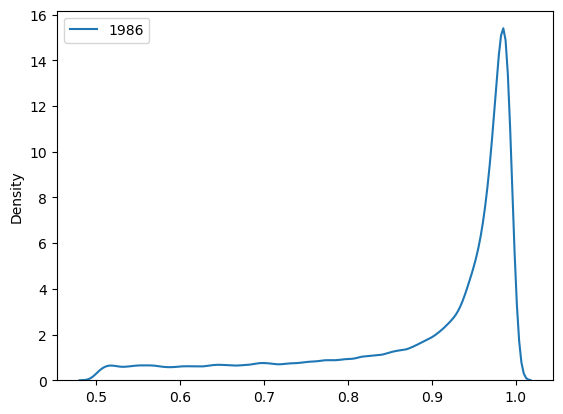

In [6]:
year = 1986
term_range = range(year, year + 5)
scores = load_scores(md[md["term"].isin(term_range)].to_dict(orient="records"), "mc")
scores = [s for s in scores if s > .5]
sns.kdeplot(scores, label= year, bw_method=.05)
# plt.xlim(.5,1)
plt.legend()
plt.show()

In [5]:
# Default bandwidth = https://stackoverflow.com/questions/21418277/gaussian-kde-with-skewed-distributions

kde = sm.nonparametric.KDEUnivariate(scores)
kde.fit()
kde.bw
sm.robust.scale.mad(scores)

In [7]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [12]:
score_tuples = []
for year in range(1986, 2018, 5):
    term_range = range(year, year + 5)
    target_opinions = md[(md["term"].isin(term_range)) & (md["is_stat_int"])].to_dict(orient="records")
    scores = load_scores(target_opinions, category="ft")
    scores = [s for s in scores if s > .6]
    scores_and_terms = list(zip(scores, ([f"{year}-{year + 5}"] * len(scores))))
    score_tuples.append(scores_and_terms)


In [13]:
df = pd.DataFrame(list(chain(*score_tuples)), columns=["score", "term"])

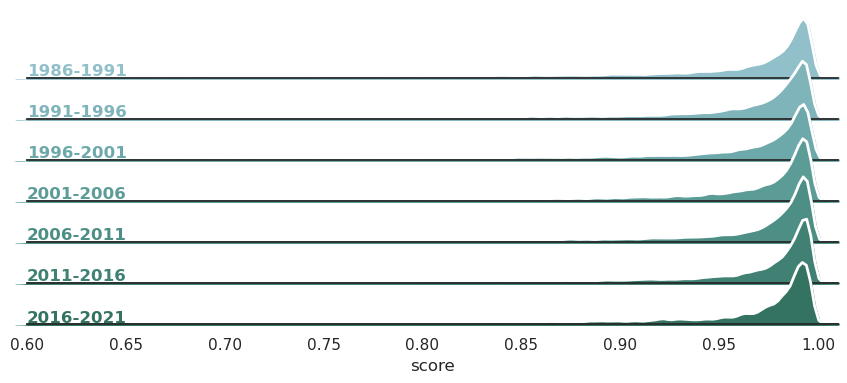

In [15]:
# Ridge plot from:
# https://seaborn.pydata.org/examples/kde_ridgeplot

pal = sns.cubehelix_palette(11, start=2,rot=.25, light=.7)
g = sns.FacetGrid(df, row="term", hue="term", aspect=15, height=.6, palette=pal, xlim=(.6,1.01))

g.map(sns.kdeplot, "score",
      bw_method=.02, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw_method=.02)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(score, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "score")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(left=True)